(difference_in_differences)=
# Difference in differences

:::{post} Sept, 2022
:tags: counterfactuals, causal inference, time series, regression, posterior predictive, difference in differences, quasi experiments
:category: beginner
:author: Benjamin T. Vincent
:::

## XXX
Some introduction here

In [1]:
import aesara.tensor as at
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import xarray as xr

from scipy.stats import norm

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## Difference in Differences

### Causal DAG

TODO

![](DAG_difference_in_differences.png)

Without `Group` then `Time` is a confounder of the `Treatment` $\rightarrow$ `Outcome` relationship

### Define the difference in differences model

I'm defining this model slightly differently compared to what you might find in other sources. This is to facilitate counterfactual inference later on in the notebook.

$$
\mu_i = \beta_{c} 
        + (\beta_{\Delta} \cdot \mathrm{group}_i)
        + (\mathrm{trend} \cdot t_i)
        + (\Delta \cdot \mathrm{treated}_i \cdot \mathrm{group}_i)
$$

where there are the following predictor variables:
* $\mu_i$ is the expected value of the $i^{th}$ observation
* $\beta_c$ is the intercept for the control group
* $\beta_{\Delta}$ is a deflection of the treatment group intercept from the control group intercept
* $\Delta$ is the causal impact of the treatment

and the following observed data points:
* $t$ is time, scaled conveniently so that the pre-intervention measurement time is at $t=0$ and the post-intervention measurement time is $t=1$
* $\mathrm{group}$ is a dummary variable for control ($g=0$) or treatment ($g=1$) group
* $\mathrm{trend}$ is the slope, and a core assumption of the model is that the slopes are identical for both groups
* $\mathrm{treated}_i$ is a binary indicator variable for untreated or treated

In [3]:
def is_treated(t, intervention_time, group):
    """Treatment is dermined both by the group and whether t>intervention time
    - group = {0, 1}"""
    return (t > intervention_time) * group


def outcome(t, control_intercept, treat_intercept_delta, trend, Δ, group, treated):
    mu = control_intercept + (treat_intercept_delta * group) + (t * trend) + (Δ * treated * group)
    return mu

### Visualise the difference in differences model

In [4]:
# true parameters
control_intercept = 1
treat_intercept_delta = 0.25
trend = 1
Δ = 1
intervention_time = 0.5

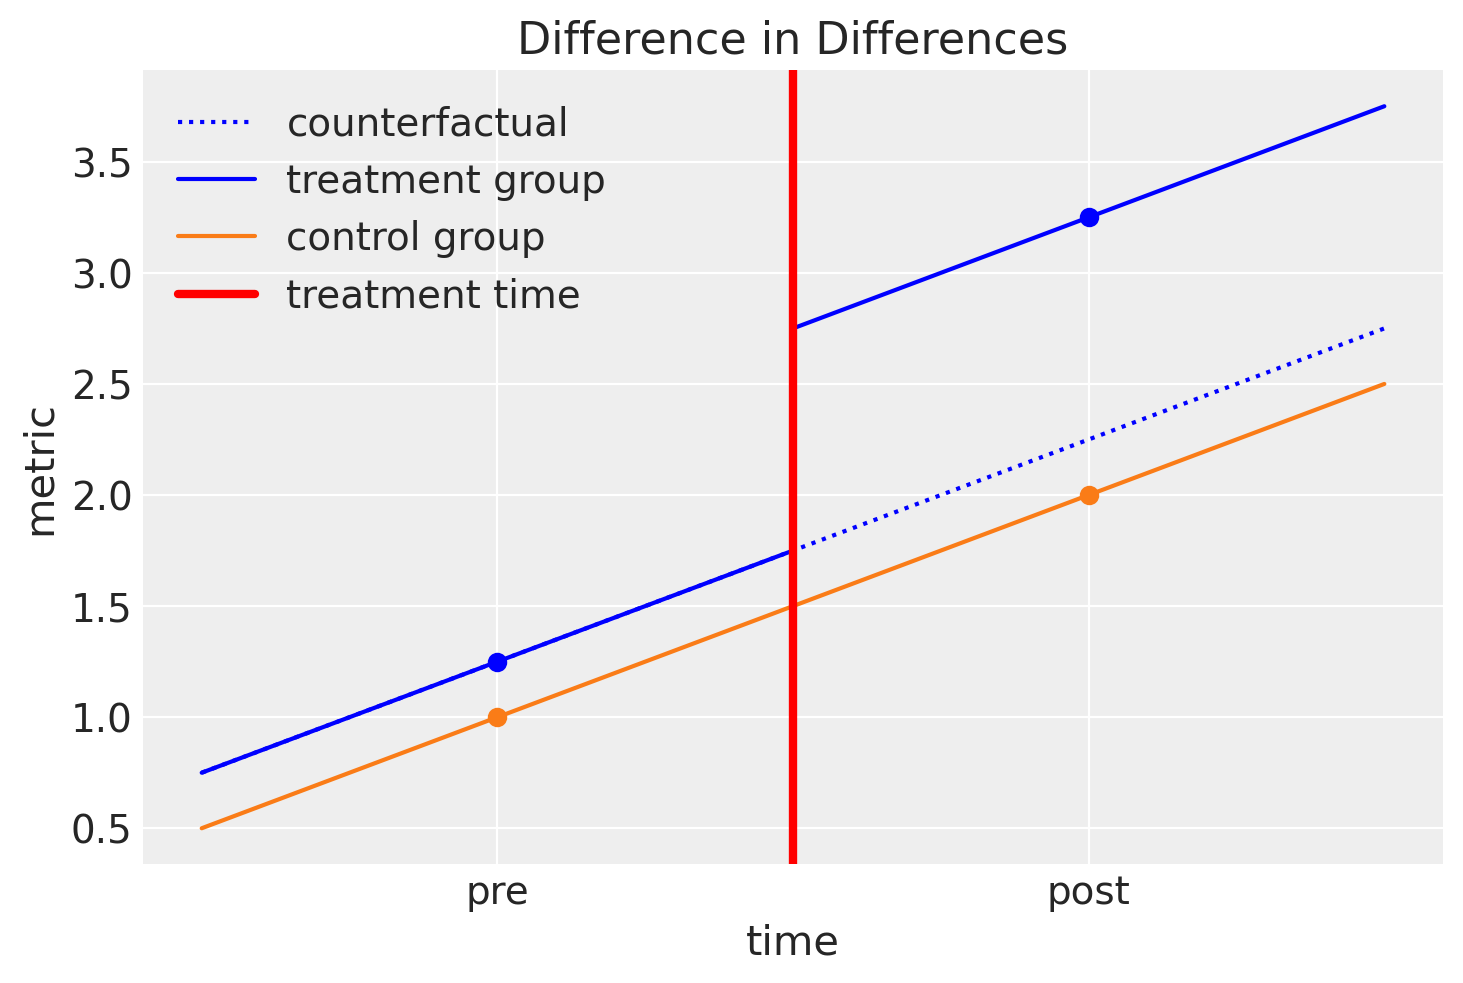

In [5]:
t = np.linspace(-0.5, 1.5, 1000)

fig, ax = plt.subplots()
ax.plot(
    t,
    outcome(
        t,
        control_intercept,
        treat_intercept_delta,
        trend,
        Δ=0,
        group=1,
        treated=is_treated(t, intervention_time, group=1),
    ),
    color="blue",
    label="counterfactual",
    ls=":",
)
ax.plot(
    t,
    outcome(
        t,
        control_intercept,
        treat_intercept_delta,
        trend,
        Δ,
        group=1,
        treated=is_treated(t, intervention_time, group=1),
    ),
    color="blue",
    label="treatment group",
)
ax.plot(
    t,
    outcome(
        t,
        control_intercept,
        treat_intercept_delta,
        trend,
        Δ,
        group=0,
        treated=is_treated(t, intervention_time, group=0),
    ),
    color="C1",
    label="control group",
)
ax.axvline(x=intervention_time, ls="-", color="r", label="treatment time", lw=3)
t = np.array([0, 1])
ax.plot(
    t,
    outcome(
        t,
        control_intercept,
        treat_intercept_delta,
        trend,
        Δ,
        group=1,
        treated=is_treated(t, intervention_time, group=1),
    ),
    "o",
    color="blue",
)
ax.plot(
    t,
    outcome(
        t,
        control_intercept,
        treat_intercept_delta,
        trend,
        Δ=0,
        group=0,
        treated=is_treated(t, intervention_time, group=0),
    ),
    "o",
    color="C1",
)
ax.set(
    xlabel="time",
    ylabel="metric",
    xticks=[0, 1],
    xticklabels=["pre", "post"],
    title="Difference in Differences",
)
ax.legend();

This is a good point to mention some of the other aspects of the difference in differences approach:
* You want the control and treatment groups to be as similar to each other as possible (i.e. $\beta_\Delta \rightarrow 0$). A large difference in the pre-treatment measures suggests that the groups are _not_ that similar. This opens up the possibility that there are unobserved confounders that could provide an alternative explanation to any treatment effect detected.
* The _parallel trends assumption_ is a major one! if we draw lines through the pre and post treatment outcomes for each group individually then we get 2 slopes. If the slopes are very different, then the _only_ way we can attribute that to a treatment effect is to assume that the slopes (change in groups over time) are identical. Ideally we would be able to measure at multiple time points, but this then turns the approach into more of an interrupted time series design. Without that, you have to carefully examine and justify if the parallel trends assumption is reasonable to make in your case.

## Generate a synthetic dataset

In [6]:
df = pd.DataFrame({"group": [0, 0, 1, 1] * 10, "t": [0.0, 1.0, 0.0, 1.0] * 10})

df["treated"] = is_treated(df["t"], intervention_time, df["group"])

df["y"] = outcome(
    df["t"],
    control_intercept,
    treat_intercept_delta,
    trend,
    Δ,
    df["group"],
    df["treated"],
)
df["y"] += norm(0, 0.1).rvs(df.shape[0])
df.head()

,group,t,treated,y
0,0,0.0,0,0.873119
1,0,1.0,0,1.967663
2,1,0.0,0,1.272487
3,1,1.0,1,3.330547
4,0,0.0,0,0.919144


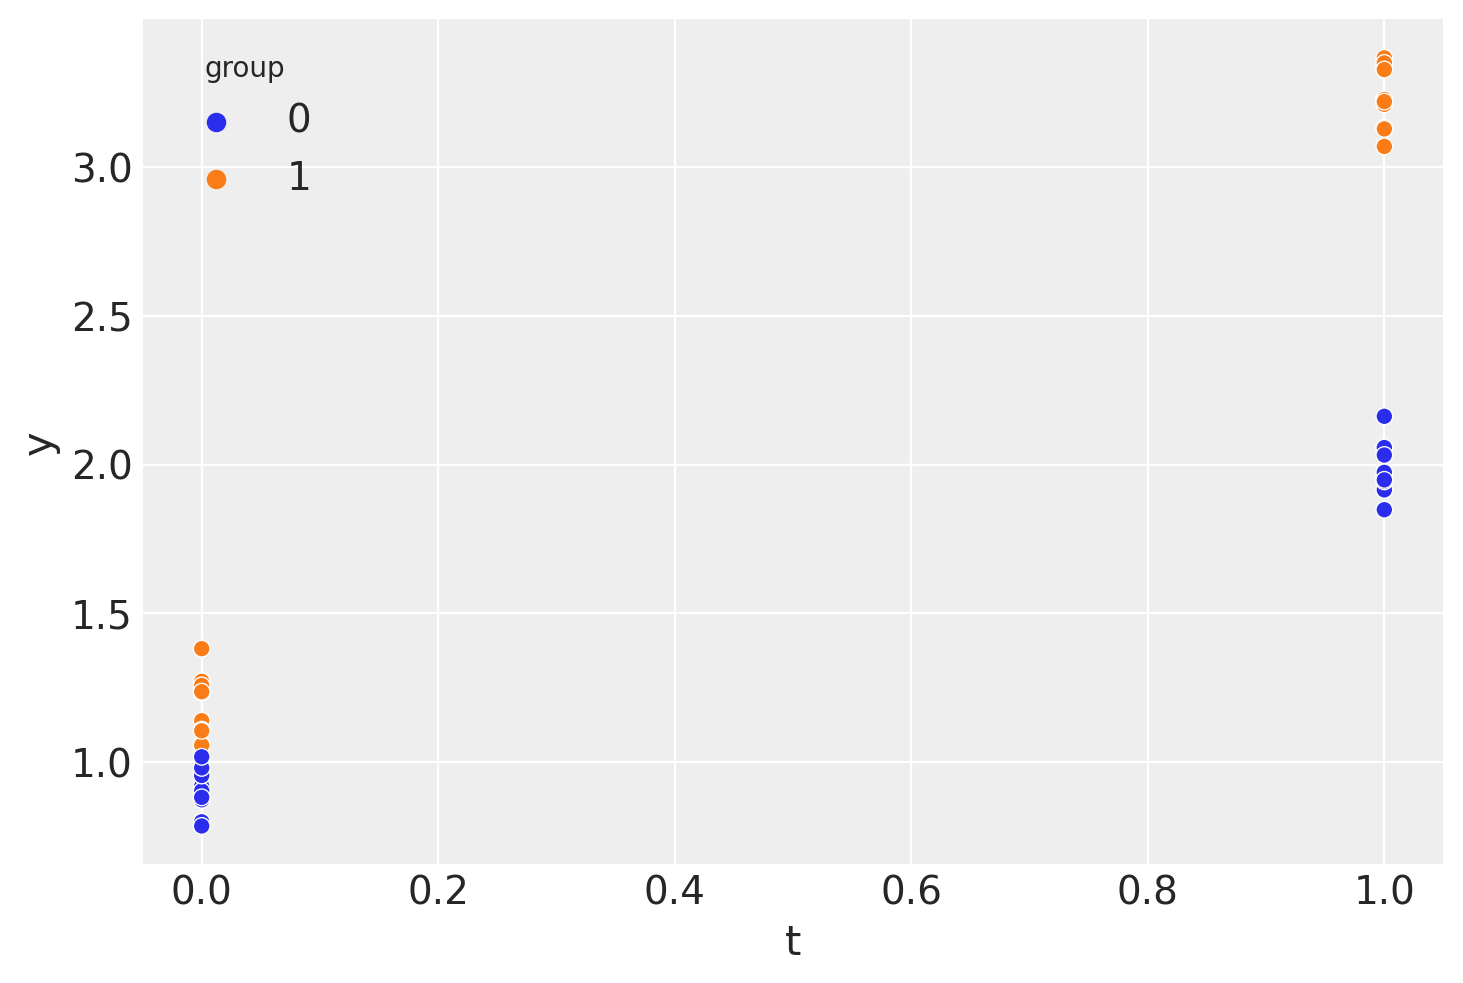

In [7]:
sns.scatterplot(df, x="t", y="y", hue="group");

## Bayesian difference in differences

### PyMC model

In [8]:
with pm.Model() as model:
    # data
    t = pm.MutableData("t", df["t"].values, dims="obs_idx")
    treated = pm.MutableData("treated", df["treated"].values, dims="obs_idx")
    group = pm.MutableData("group", df["group"].values, dims="obs_idx")
    # priors
    _control_intercept = pm.Normal("control_intercept", 0, 5)
    _treat_intercept_delta = pm.Normal("treat_intercept_delta", 0, 1)
    _trend = pm.Normal("trend", 0, 5)
    _Δ = pm.Normal("Δ", 0, 1)
    sigma = pm.HalfNormal("sigma", 1)
    # expectation
    mu = pm.Deterministic(
        "mu",
        outcome(t, _control_intercept, _treat_intercept_delta, _trend, _Δ, group, treated),
        dims="obs_idx",
    )
    # likelihood
    pm.Normal("obs", mu, sigma, observed=df["y"].values, dims="obs_idx")

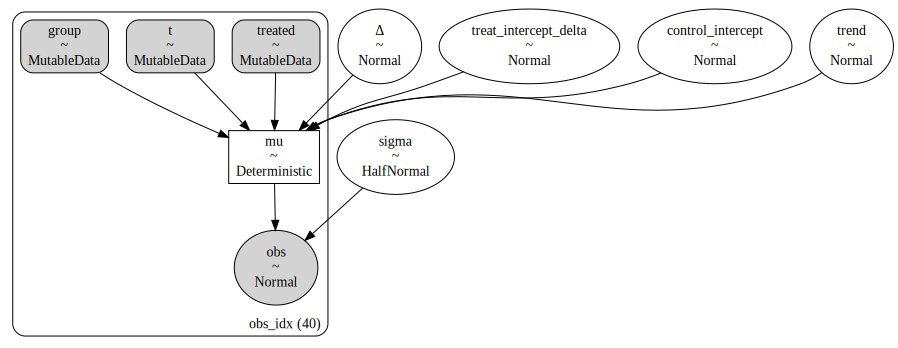

In [9]:
pm.model_to_graphviz(model)

### Inference

In [10]:
with model:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [control_intercept, treat_intercept_delta, trend, Δ, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


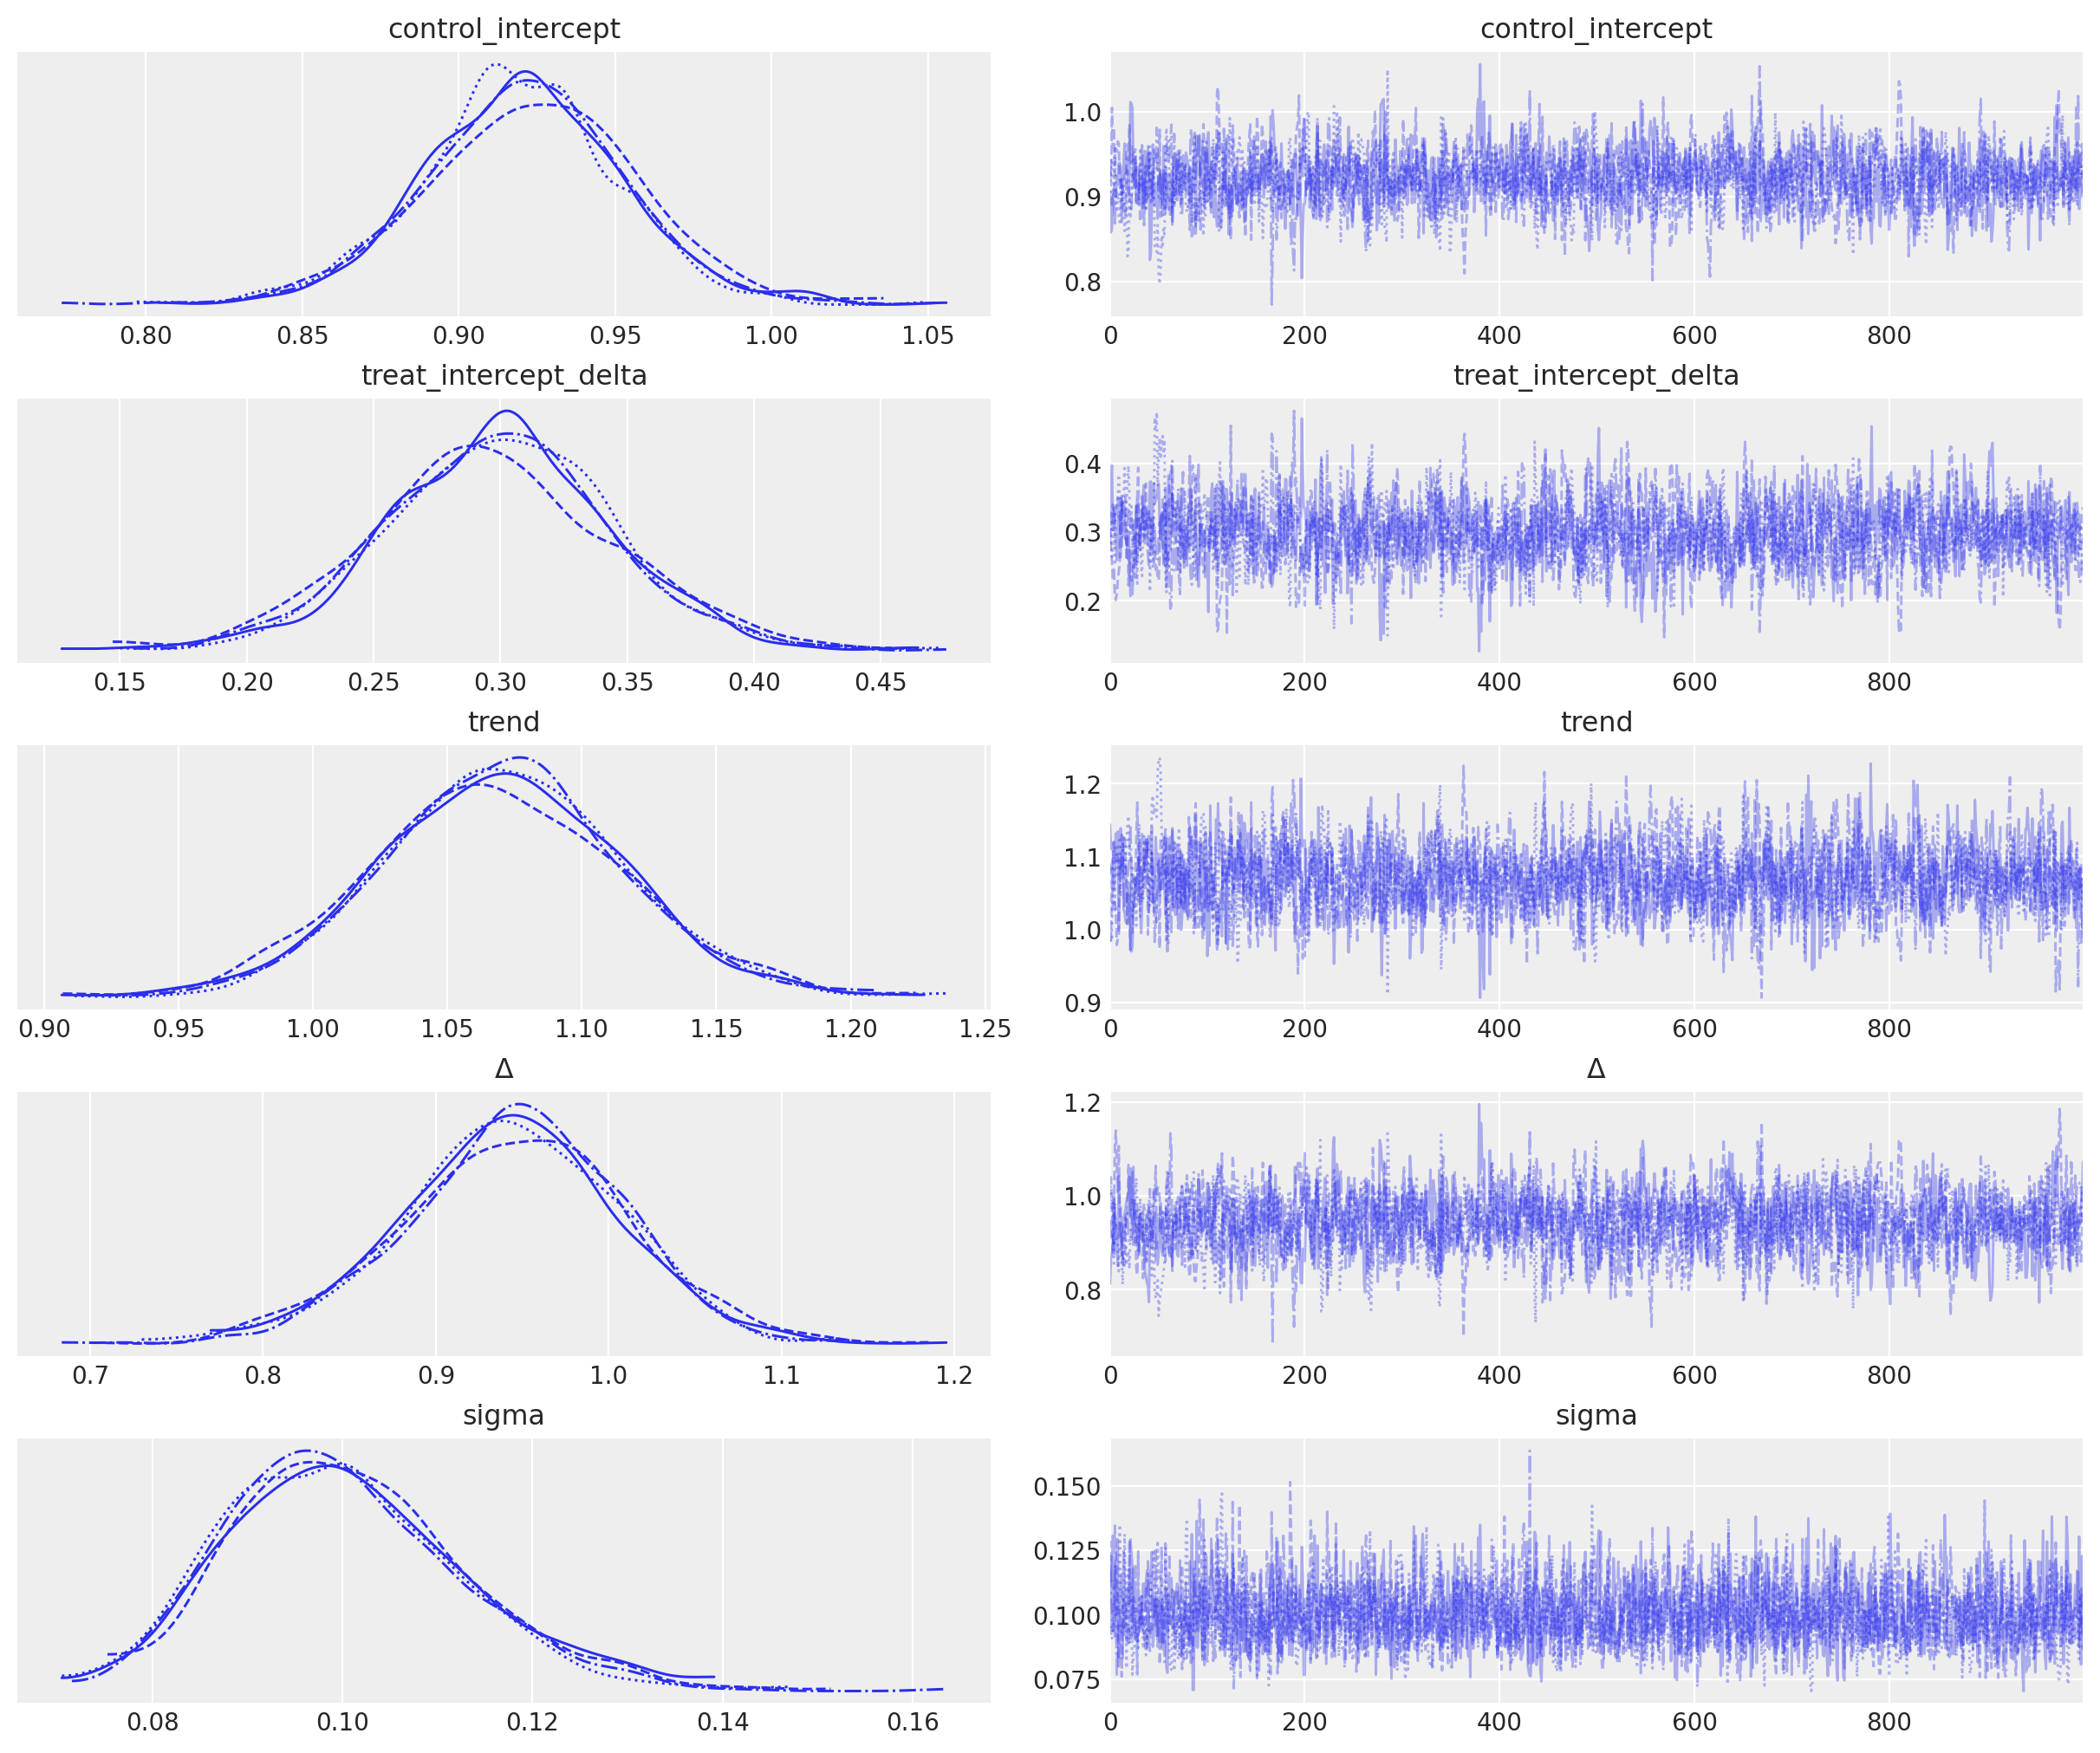

In [11]:
az.plot_trace(idata, var_names="~mu");

## Posterior prediction
NOTE: Technically we are doing 'pushforward prediction' for $\mu$ as this is a deterministic function of it's inputs.

In [12]:
t = np.linspace(-0.5, 1.5, 100)

# pushforward predictions for control group
with model:
    group_control = [0] * len(t)  # must be integers
    treated = [0] * len(t)  # must be integers
    pm.set_data({"t": t, "group": group_control, "treated": treated})
    ppc_control = pm.sample_posterior_predictive(idata, var_names=["mu"])

# pushforward predictions for treatment group
with model:
    group = [1] * len(t)  # must be integers
    pm.set_data(
        {
            "t": t,
            "group": group,
            "treated": is_treated(t, intervention_time, group),
        }
    )
    ppc_treatment = pm.sample_posterior_predictive(idata, var_names=["mu"])

# counterfactual: what do we predict of the treatment group if they had _not_ been treated
t_counterfactual = np.linspace(
    0.5, 1.5, 100
)  # we want to know about just the post intervention times
with model:
    group = [1] * len(t_counterfactual)  # must be integers
    pm.set_data(
        {
            "t": t_counterfactual,
            "group": group,
            "treated": [0] * len(t_counterfactual),  # THIS IS OUT COUNTERFACTUAL
        }
    )
    ppc_counterfactual = pm.sample_posterior_predictive(idata, var_names=["mu"])

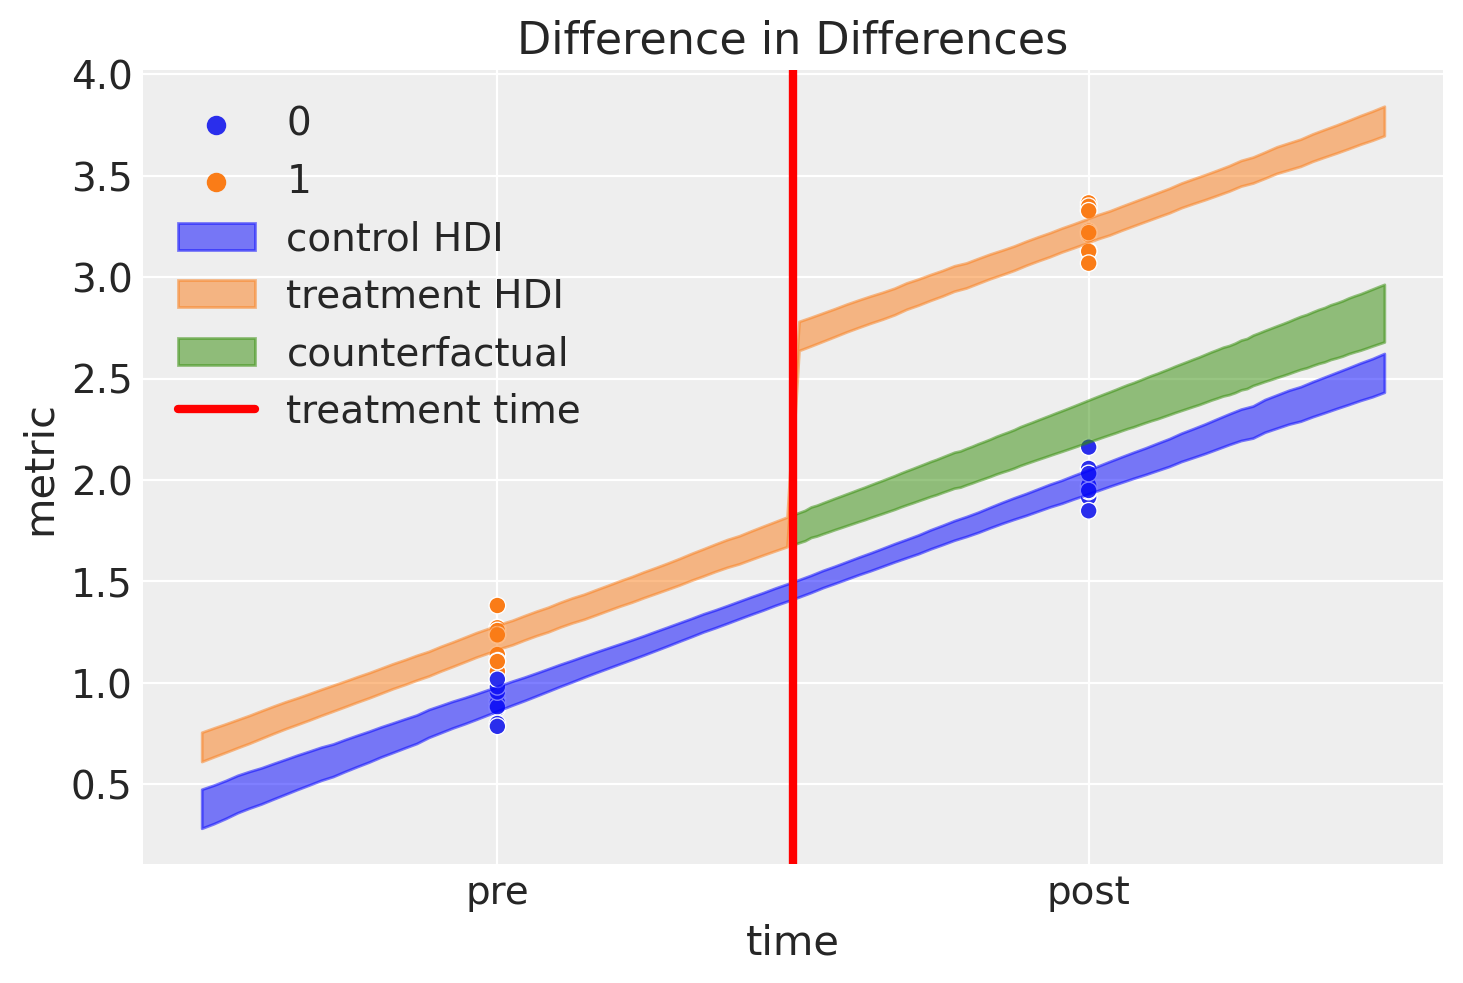

In [13]:
ax = sns.scatterplot(df, x="t", y="y", hue="group")

az.plot_hdi(
    t,
    ppc_control.posterior_predictive["mu"],
    smooth=False,
    ax=ax,
    color="blue",
    fill_kwargs={"label": "control HDI"},
)
az.plot_hdi(
    t,
    ppc_treatment.posterior_predictive["mu"],
    smooth=False,
    ax=ax,
    color="C1",
    fill_kwargs={"label": "treatment HDI"},
)
az.plot_hdi(
    t_counterfactual,
    ppc_counterfactual.posterior_predictive["mu"],
    smooth=False,
    ax=ax,
    color="C2",
    fill_kwargs={"label": "counterfactual"},
)
ax.axvline(x=intervention_time, ls="-", color="r", label="treatment time", lw=3)
ax.set(
    xlabel="time",
    ylabel="metric",
    xticks=[0, 1],
    xticklabels=["pre", "post"],
    title="Difference in Differences",
)
ax.legend();

This is an awesome plot, but there are quite a few things going on here, so let's go through it:
* Blue shaded region represents credible regions for the expected value of the control group
* Orange shaded region represents similar regions for the treatment group. We can see how the outcome jumps immediately after the intervention.
* The green shaded region is something pretty novel, and nice. This represents our counterfactual inference of _what we would expect if_ the treatment group were never given the treatment. By definition, we never made any observations of items in the treatment group that were not treated after the intervention time. Nevertheless, with the model described at the top of the notebook and the Bayesian inference methods outlined, we can region about such _what if_ questions. 
* The difference between this counterfactual expectation and the observed values (post treatment in the treatment condition) represents our inferred causal impact of the treatment. Let's take a look at that posterior distribution in more detail:

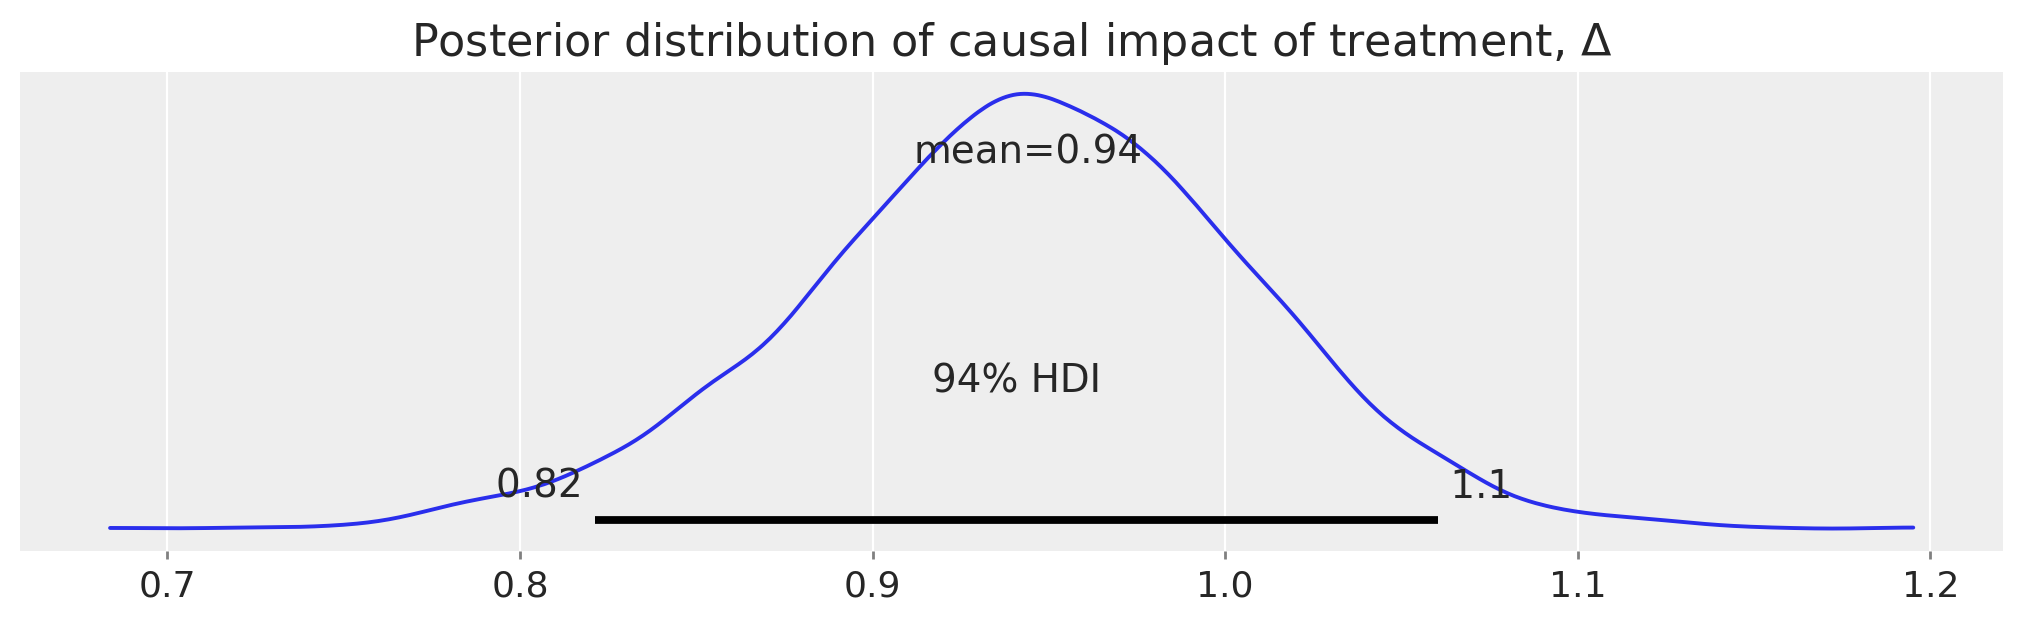

In [14]:
ax = az.plot_posterior(idata.posterior["Δ"], figsize=(10, 3))
ax.set(title=r"Posterior distribution of causal impact of treatment, $\Delta$");

## References

:::{bibliography}
:filter: docname in docnames
:::

## Authors
- Authored by [Benjamin T. Vincent](https://github.com/drbenvincent) in Sept 2022.

## Watermark

In [15]:
%load_ext watermark
%watermark -n -u -v -iv -w -p aesara,aeppl,xarray

Last updated: Fri Sep 23 2022

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

aesara: 2.8.2
aeppl : 0.0.35
xarray: 2022.6.0

aesara    : 2.8.2
numpy     : 1.23.3
arviz     : 0.12.1
seaborn   : 0.12.0
pymc      : 4.2.0
matplotlib: 3.6.0
xarray    : 2022.6.0
pandas    : 1.5.0

Watermark: 2.3.1



:::{include} ../page_footer.md
:::